In [1]:
from functools import partial
import time

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from adaptive_swim.ansatz import BoundaryCompliantAnsatz
from swimpde.boundary import PeriodicStrict
from swimpde.domain import Domain
from swimpde.equation import Advection
from swimpde.solver import TimeDependentSolver

from utils import compute_metrics, plot_results

Parameters of the equation

In [2]:
def intial_condition(x: npt.ArrayLike) -> npt.ArrayLike:
    return np.sin(x) # u(x, 0) = sin(x)

def forcing(x: npt.ArrayLike, _: float) -> npt.ArrayLike:
    return np.zeros((x.shape[0], 1)) # No forcing term f(x, _) = 0 (time-independent)

def solution(x: npt.ArrayLike, t: float, beta: float) -> npt.ArrayLike:
    return np.sin(x - beta * t)

beta = 40
boundary_condition = PeriodicStrict()

x_span = 0, 2*np.pi
t_span = 0, 1

Create data for evaluation

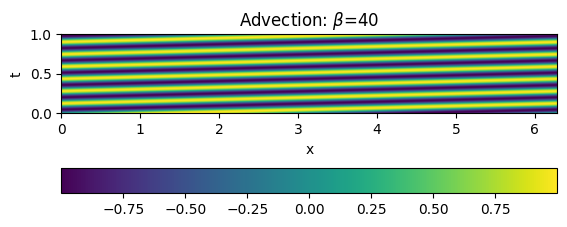

Create a domain

In [4]:
n_domain_points = 400 # collocation points in the spatial domain, N_c
x_space = np.linspace(*x_span, n_domain_points)[:, None]

x_interior = x_space[1:-1]
x_boundary = x_space[[0, -1]]
domain = Domain(interior_points=x_interior,
                boundary_points=x_boundary)

Solve the equation

In [5]:
# Parameters of the solver 
n_basis = 25 # number of outer basis functions, A\phi(x)
n_inner_basis = 200 # number of inner basis functions, random features, \phi = \sigma(Wx + b)
n_time_steps = 100
activation = "a_tanh"
random_seed = 42
regularization_scale = 1e-11
rtol = 1e-10 # relative tolerance for ODE solver
atol = 1e-10

In [6]:
# A target for the basis functions.
# (target functions that already satisfy periodic BCs)
# Advection: sin(kx) for k even, cos(kx) for k odd
# Input: x (n_points, 1)
# Output: (n_points, n_basis)
def periodic_target_fn(x, n_basis):
    # We need to create one extra function if n_basis is odd.
    n_pairs = (n_basis + 1) // 2
    scales = np.arange(1, n_pairs + 1)
    sin_transforms = np.sin(x * scales)
    cos_transforms = np.cos(x * scales)
    transforms = np.column_stack([sin_transforms, cos_transforms])
    # Cut this extra function out if n_basis is odd.
    return transforms[:, :n_basis]


# Define the ansatz A\phi(x).
ansatz = BoundaryCompliantAnsatz(
    n_basis=n_basis,
    n_inner_basis=n_inner_basis,
    activation=activation,
    random_seed=random_seed,
    target_fn=partial(periodic_target_fn, n_basis=n_basis),
    boundary_condition=boundary_condition,
    regularization_scale=regularization_scale,
)

# Define the equation.
equation = Advection(u0=intial_condition, beta=beta)

# Define the solver.
solver = TimeDependentSolver(
    domain=domain,
    ansatz=ansatz,
    forcing=forcing,
    equation=equation,
    regularization_scale=regularization_scale,
    rtol=rtol,
    atol=atol,
)

# Fit the solver.
start_fit = time.time()
solver.fit(t_span=t_span)
end_fit = time.time()
training_time = end_fit - start_fit

print(f"Training time: {training_time:.4f}s")


(398, 1) (398, 25) (1, 200) (1, 200)
[[0.6494276  0.65635514 0.6527621  0.64989775 0.64961284 0.64746106
  0.64916044 0.46047354 0.6465508  0.46047184 0.6644176  0.6119862
  0.6504165  0.65132684 0.64982784 0.6480988  0.64908785 0.64261055
  0.65036124 0.64186525 0.6464198  0.64978397 0.6433646  0.6490794
  0.6459413  0.64261055 0.6421959  0.6466564  0.65127015 0.6414157
  0.65635514 0.66472507 0.6490794  0.649318   0.6414157  0.6610342
  0.64743775 0.6501894  0.6511421  0.6494276  0.6567146  0.6421959
  0.6489937  0.6509777  0.65127015 0.6447671  0.6414157  0.64864653
  0.46047354 0.64960414 0.64209795 0.65052795 0.61192226 0.64853215
  0.6567146  0.6424789  0.64336926 0.64746106 0.6491571  0.46053168
  0.65008086 0.64933664 0.6579383  0.6491551  0.66097736 0.64908785
  0.65052724 0.6541909  0.64627796 0.64928585 0.6502307  0.6466564
  0.6490794  0.6119862  0.6490977  0.6541909  0.6503136  0.6490794
  0.65029633 0.6493208  0.66442794 0.6511421  0.46047354 0.64706916
  0.6518756  0.642

/Users/kinanguyen24/Documents/TUM BACHELOR INFORMATIK/7. SEMESTER/Thesis/adaptive_swim_pde/.venv/lib/python3.12/site-packages/swimpde/solver/time_solver.py:243: UserWarning: Solution of the ODE system diverged in the block #1.
  warnings.warn(


Evaluate the solver

Relative error: 3.170E+13


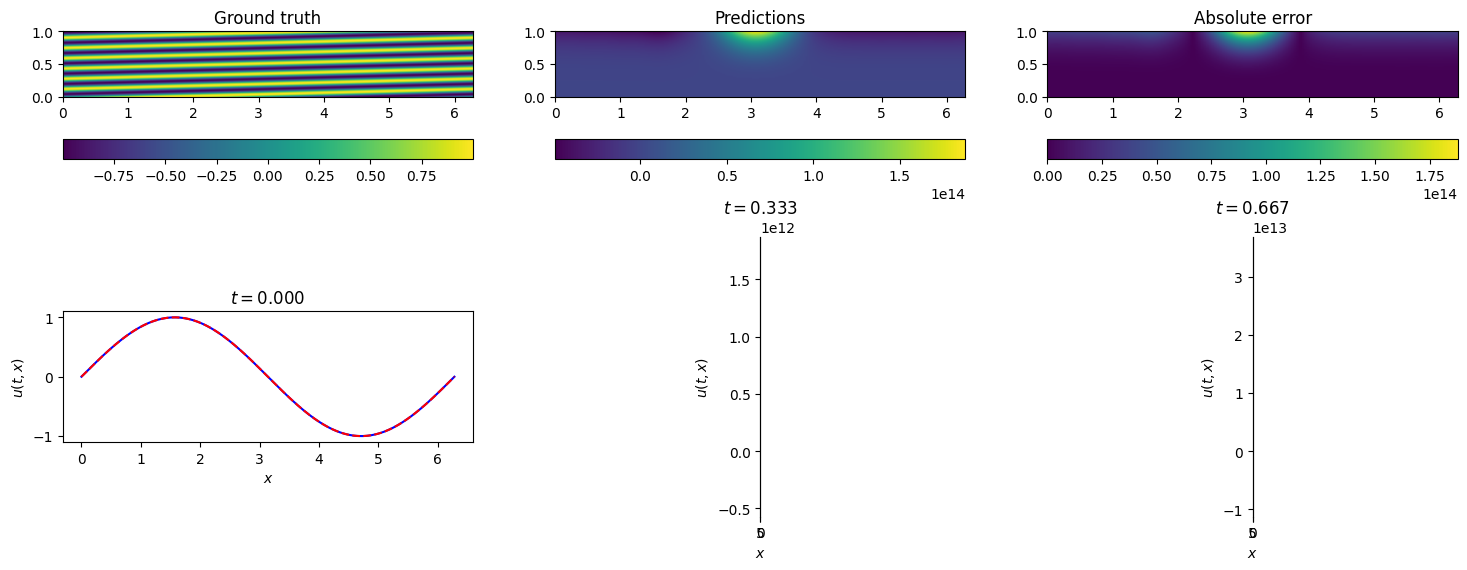

In [7]:
u_pred = solver.evaluate(x_eval, t_eval)
abs_error, rel_l2_error = compute_metrics(u_pred, u_exact)

print(fr"Relative error: {rel_l2_error:.3E}")
fig = plot_results(x_eval, t_eval, u_exact, u_pred, abs_error)